# Examples -- Change in streamflow by elevation

In this example, we will look at HUC4 1803 and 1804 to the west of the San Francisco Bay. This includes the High Sierras to the bay.

![](https://noaa-nwfsc.github.io/Streamflow-Means-NWM/wr1718_map.png)

## Load the data.

In [1]:
import warnings
warnings.filterwarnings("ignore", message="Your application has authenticated using end user credentials")

import xarray as xr
zarr_url = "gcs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/streamflow/zarr"
ds = xr.open_zarr(zarr_url, consolidated=True)

# add HUC4 as a coordinate
rc = ds.REACHCODE.astype(str).values
# Extract HUC4 (first 4 characters) as unicode not bytecode
huc4 = rc.astype("U4")

# Add as a coordinate
ds = ds.assign_coords(HUC4=("feature_id", huc4.data))

## Add elevation bands

In [66]:
import xarray as xr
import numpy as np

# Define elevation bins (in meters)
bins = [-500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]
labels = [f"{bins[i]}–{bins[i+1]} m" for i in range(len(bins)-1)]

# Bin the elevation values
elevation_band = xr.apply_ufunc(
    np.digitize,
    ds.elevation,
    kwargs={"bins": bins},
    dask="allowed",
    output_dtypes=[int],
    vectorize=True  # <- this is key
)

# Now add this band info as a coordinate
ds = ds.assign_coords(elevation_band=("feature_id", elevation_band.data))

In [ ]:
# Only keep values in valid range (1 to len(bins) - 1)
band_values = ds.elevation_band.values.astype(int)
valid_band_values = [i for i in band_values if 1 <= i < len(bins)]
labels_present = [f"{bins[i-1]}–{bins[i]} m" for i in valid_band_values]

# Assign (make sure ordering matches)
#ds = ds.sel(elevation_band=valid_band_values)
#ds = ds.assign_coords(elevation_band=("elevation_band", labels_present))

In [ ]:
len(labels_present)

In [65]:
ds.elevation.min().compute()

<xarray.DataArray 'elevation' ()> Size: 4B
array(-99.98, dtype=float32)

## Get the averages by elevation band and HUC4

In [15]:
# Mean by elevation band and HUC4
elevation_huc4_ts = ds.streamflow.groupby(["HUC4", "elevation_band"]).mean(dim="feature_id")

In [17]:
print(elevation_huc4_ts)

<xarray.DataArray 'streamflow' (time: 16072, HUC4: 22, elevation_band: 8)> Size: 23MB
dask.array<reshape, shape=(16072, 22, 8), dtype=float64, chunksize=(365, 1, 8), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 129kB 1979-02-01 ... 2023-02-01
  * HUC4            (HUC4) object 176B '1701' '1702' '1703' ... '1809' '1810'
  * elevation_band  (elevation_band) int64 64B 0 1 2 3 4 5 6 7
Attributes:
    description:    Daily mean streamflow calculated from hourly NWM v3.0 str...
    grid_mapping:   crs
    long_name:      streamflow (discharge)
    standard_name:  river_discharge
    units:          m3 s-1


In [32]:
elevation_huc4_ts.to_netcdf("elevation_huc4_ts.nc")

In [ ]:
import xarray as xr
elevation_huc4_ts = xr.open_dataset("elevation_huc4_ts.nc")

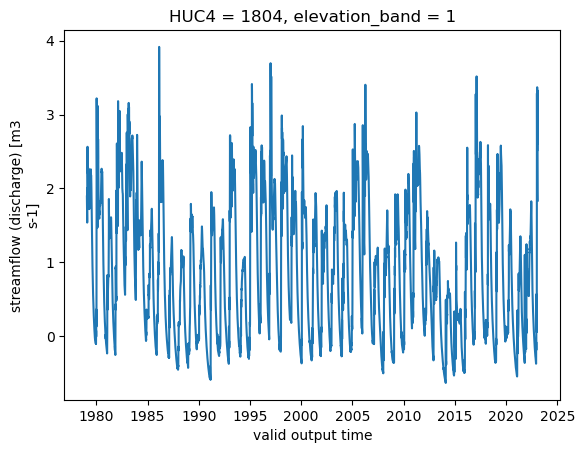

In [42]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# 1. Take log of flow (add small epsilon to avoid log(0))
log_flow = np.log(elevation_huc4_ts)
log_flow.streamflow.sel(HUC4="1804", elevation_band=1).plot()

In [35]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# 1. Take log of flow (add small epsilon to avoid log(0))
log_flow = np.log(elevation_huc4_ts + 1e-6)

# 2. Compute % change from first to last time point
pct_change = 100 * (log_flow.isel(time=-1) - log_flow.isel(time=0))

# 3. Convert to tidy DataFrame for plotting
df = pct_change.to_dataframe(name="percent_change").reset_index()

# 4. Plot
plt.figure(figsize=(10, 6))
for band in sorted(df["elevation_band"].unique()):
    band_df = df[df["elevation_band"] == band]
    plt.plot(band_df["HUC4"], band_df["percent_change"], label=f"Band {band}", marker="o")

plt.xlabel("HUC4")
plt.ylabel("% Change in log(streamflow)")
plt.title("Percent Change in Log Streamflow by HUC4 and Elevation Band")
plt.legend(title="Elevation Band")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


TypeError: Dataset.to_dataframe() got an unexpected keyword argument 'name'

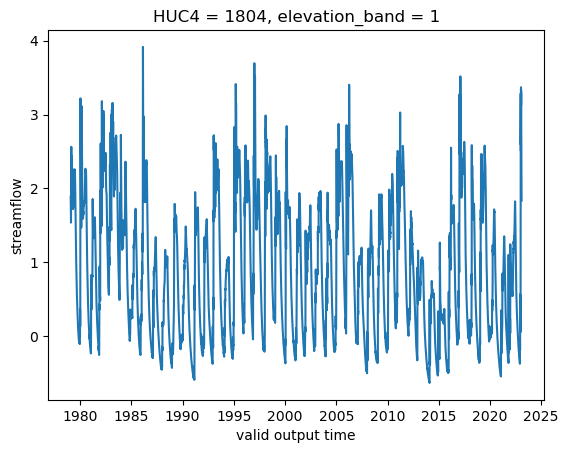

In [31]:
log_flow.sel(HUC4="1804", elevation_band=1).plot()

In [15]:
%%time
# Compute the actual values 
elevation_ts = elevation_ts.compute()


CPU times: user 19.5 s, sys: 3.83 s, total: 23.3 s
Wall time: 27.1 s


In [56]:
elevation_ts.to_netcdf("banded_streamflow_by_elevation.nc")

In [16]:
# Get band labels
banded_ts = elevation_ts
band_values = banded_ts.elevation_band.values.astype(int)

# Only keep values in valid range (1 to len(bins) - 1)
valid_band_values = [i for i in band_values if 1 <= i < len(bins)]

# Build labels safely
labels_present = [f"{bins[i-1]}–{bins[i]} m" for i in valid_band_values]

# Assign to banded_ts (make sure ordering matches)
banded_ts = banded_ts.sel(elevation_band=valid_band_values)
banded_ts = banded_ts.assign_coords(
    elevation_band=("elevation_band", labels_present)
)


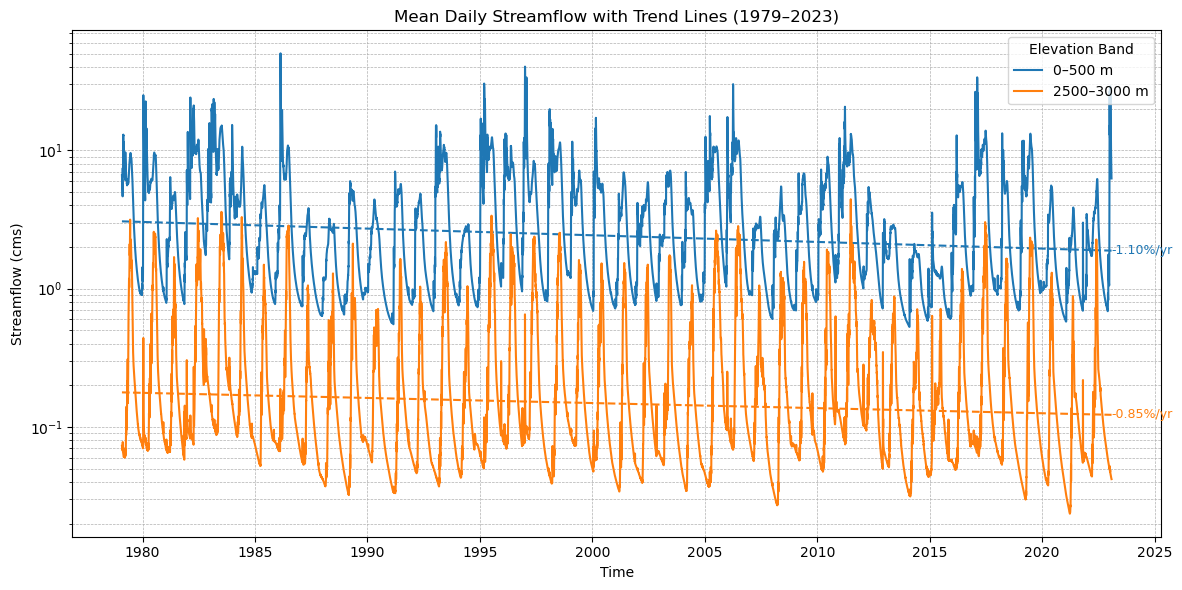

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

fig, ax = plt.subplots(figsize=(12, 6))

banded_ts_sel = banded_ts.sel(elevation_band=["0–500 m", "2500–3000 m"])

for label in banded_ts_sel.elevation_band.values:
    ts = banded_ts_sel.sel(elevation_band=label)

    # Convert time to decimal years
    time = banded_ts_sel.time
    years = (time.dt.year + time.dt.dayofyear / 365).values
    flow = ts.values

    # Mask to avoid log(0) or NaNs
    mask = np.isfinite(flow) & (flow > 0)

    # Plot raw data (with legend)
    ax.plot(time, flow, label=label)

    # Linear regression on log(flow)
    log_flow = np.log(flow[mask])
    slope, intercept, *_ = linregress(years[mask], log_flow)

    # Create and plot trendline (no label → no legend entry)
    trend = np.exp(intercept + slope * years)
    ax.plot(time, trend, linestyle="--", color=ax.lines[-1].get_color())

    # Compute percent change per year
    pct_per_year = (np.exp(slope) - 1) * 100

    # Annotate near the end of the time series
    ax.text(
        time[-1].values,
        trend[-1],
        f"{pct_per_year:+.2f}%/yr",
        fontsize=9,
        verticalalignment="center",
        color=ax.lines[-1].get_color()
    )

ax.set_title("Mean Daily Streamflow with Trend Lines (1979–2023)")
ax.set_xlabel("Time")
ax.set_ylabel("Streamflow (cms)")
ax.set_yscale("log")
ax.legend(title="Elevation Band", loc="upper right")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()



In [22]:
summary_lines = []

for label in banded_ts_sel.elevation_band.values:
    ts = banded_ts_sel.sel(elevation_band=label)

    # Convert time to decimal years
    time = banded_ts_sel.time
    years = (time.dt.year + time.dt.dayofyear / 365).values
    flow = ts.values

    # Mask for valid values
    mask = np.isfinite(flow) & (flow > 0)
    log_flow = np.log(flow[mask])
    slope, intercept, *_ = linregress(years[mask], log_flow)
    trend = np.exp(intercept + slope * years)

    # Total change from start to end
    flow_start = trend[0]
    flow_end = trend[-1]
    abs_change = flow_end - flow_start
    pct_change = (flow_end / flow_start - 1) * 100

    summary_lines.append(
        f"{label}: {pct_change:+.2f}% change ({abs_change:+.2f} cms) from 1979 to 2023"
    )

# Print summary
print("\nStreamflow trend summary:")
print("\n".join(summary_lines))


Streamflow trend summary:
0–500 m: -38.62% change (-1.18 cms) from 1979 to 2023
2500–3000 m: -31.18% change (-0.06 cms) from 1979 to 2023
